In [1]:
%matplotlib inline
import random
import torchvision.transforms.functional as FT
from dataset import CocoDataset
from utils   import *
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [26]:
def plt_samples(ds):
    plt.figure(figsize=(16, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        drawSample(ds[0])

# Data Augmentations

The purpose of data augmentations is to apply a series of random transforms to data samples, such that there is much more variety extending beyond what the original dataset offers. It also acts as a form of regularization to prevent overfitting on just the specific size or lighting condition that the original dataset offers. For object detection task, any form or spatial or orientation transformations applied to the input image must also be applied correspondingly to the target bounding box(es) (and even to the segmentation masks).


### Photometric Distorsions

Randomly alter the photometric aspects of the image: brightness, contrast, saturation, and hue

In [2]:
class PhotometricDistort(object):
    """
    (Ref: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py)
    Distort brightness, contrast, saturation, and hue, each with a probability of `p` chance, in random order.
    """
    def __init__(self, p):
        self.proba = p
        self.distortions = [FT.adjust_brightness,
                            FT.adjust_contrast,
                            FT.adjust_saturation,
                            FT.adjust_hue]
        
    def __call__(self, sample):
        img = sample['image']
        random.shuffle(self.distortions)
        for d in self.distortions:
            if random.random() < self.proba:
                if d.__name__ == 'adjust_hue':
                    # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                    adjust_factor = random.uniform(-18 / 255., 18 / 255.)
                else:
                    # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                    adjust_factor = random.uniform(0.5, 1.5)
                # Apply this distortion
                sample['image'] = d(sample['image'], adjust_factor)
        return sample

In [28]:
basic_tfs = [PhotometricDistort(1.)]
tfms = transforms.Compose(basic_tfs)
ds = CocoDataset(data_dir='./', dataset='val2017', anno_type='instances', transforms=tfms)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


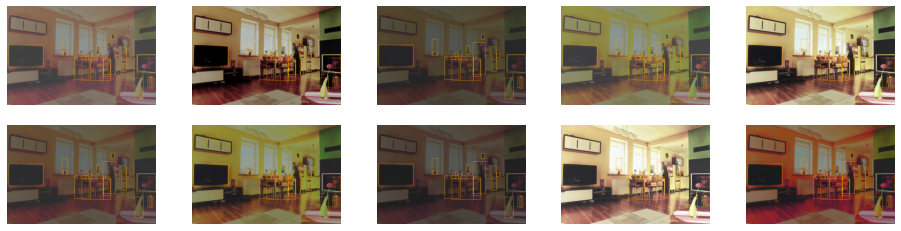

In [29]:
plt_samples(ds)

## Zoom Out

In [30]:
class Zoomout(object):
    """
    (Ref: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py)
    Perform a zooming out operation by placing the image in a larger canvas of filler material.
    Helps to learn to detect smaller objects.
    """
    def __init__(self, p, max_scale=4):
        self.proba = p
        self.max_scale = max_scale
        
        
    def __call__(self, sample):
        image = sample['image']
        boxes = sample['boxes']        
        if random.random() < self.proba:            
            _, original_h, original_w = image.size()
            scale = random.uniform(1, self.max_scale)
            new_h = int(scale * original_h)
            new_w = int(scale * original_w)

            # Create such an image with the filler
            filler  = torch.FloatTensor([image[0,:,:].mean(), image[1,:,:].mean(), image[2,:,:].mean()])  # (3)
            new_img = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)
            # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
            # because all expanded values will share the same memory, so changing one pixel will change all

            # Place the original image at random coordinates in this new image (origin at top-left of image)
            left = random.randint(0, new_w - original_w)
            right = left + original_w
            top = random.randint(0, new_h - original_h)
            bottom = top + original_h
            new_img[:, top:bottom, left:right] = image

            # Adjust bounding boxes' coordinates accordingly
            # (n_objects, 4), n_objects is the no. of objects in this image
            new_boxes = boxes + torch.FloatTensor([left, top, 0, 0]).unsqueeze(0)
            
            sample['image'] = new_img
            sample['boxes'] = new_boxes
        return sample

In [39]:
basic_tfs = [PhotometricDistort(1.), 
             ImageToTensor(), CategoryToTensor(), BoxToTensor(),
             Zoomout(1., max_scale=2.5)]
tfms = transforms.Compose(basic_tfs)
ds = CocoDataset(data_dir='./', dataset='val2017', anno_type='instances', transforms=tfms)

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


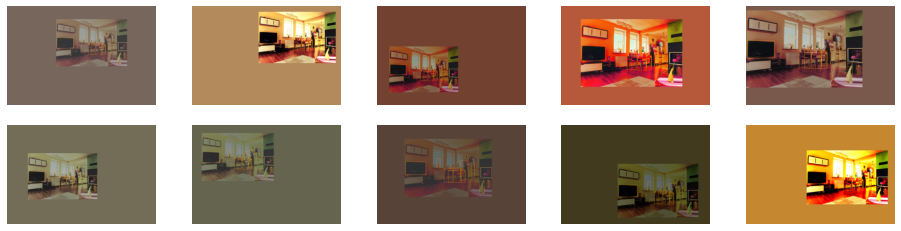

In [40]:
plt_samples(ds)

## Zoom In

## Flip

In [ ]:
class Flip(object):
    
    def __init__(self, p):
        self.proba = p
        
        
    def __call__(self, sample):
        if random.random() < self.proba:            
            image = sample['image']
            boxes = sample['boxes']        
            new_image = transforms.functional.hflip(image)
            new_boxes = 

In [ ]:
def flip(image, boxes):
    """
    Flip image horizontally.
    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

## Resize

## Normalize

## Abs Coord to Fractional Coord